In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib
from math import floor
import numpy as np
import pandas as pd
from scipy.optimize import newton
from scipy.optimize import brentq
from scipy import linalg
from scipy.interpolate import griddata
import statsmodels.api as sm
%matplotlib inline

# The following are the modules developed in testing here
from atmPy import aerosol
from atmPy import atmosphere as atmos
import atmPy.instruments.DMA.dma  as dma

from imp import reload

Before doing anything, define a simple object which will allow us to perform calculations using the properties of air.  The object ``air`` is defined in the package ``atmosphere``.  The object ``air`` is a child of the abstract class ``gas`` which has two properties, temperature and pressure.  The default conditions are $T=20^{\circ}$C and $P=1013.25$ mb.  

In [2]:
air = atmos.Air()

# DMA Calculations

Below are the equations used to define the calculations used by the DMA.  First, we calculate the electic mobility $Z_e$ as 

\begin{equation}
Z_e = \frac{e*C_c}{3\pi\mu{D}}
\end{equation}

where $\mu$ is the viscocity as a function of temperature $T$, $C_c$ is the Cunningham correction factor for particles in the transition regime and $e$ is the .

## Viscocity

In the equation above, the viscocity of air is calcualted as 

\begin{equation}
\mu = \mu_0\frac{C+T_0}{C+T}\left(\frac{T}{T_0}\right)^{1.5}
\end{equation}

This is <a href = 'http://en.wikipedia.org/wiki/Viscosity#Effect_of_temperature_on_the_viscosity_of_a_gas'>Sutherland's formula</a>.  In the above equation, the values are as follows:

* $C$ is the Sutherlan's constant.  For air this value is 120.
* $T_0$ is the reference temperature.  In this case, we use 291.15 K.
* $\mu_0$ is the corresponding reference viscocity.  For the given reference temperature, this value is 18.27e-6 Pa-s.

The cell below shows the calculation with a plot for a range of temperatures from 2 to 52 degrees Celsius.

In [3]:
T0 = 275 # Initial temperature for plotting
T1 = 325 # Final temperature for plotting


def mu(T):
    air.t = T
    return air.mu()

# range of viscocity covering the range of temperature above
z = [mu(i) for i in range(T0,T1)]

# List of temperatures in Kelvin
x = list(range(275,325))

# Convert the list of temperatures to degrees Celsius
x = [float(i)-273.15 for i in x]

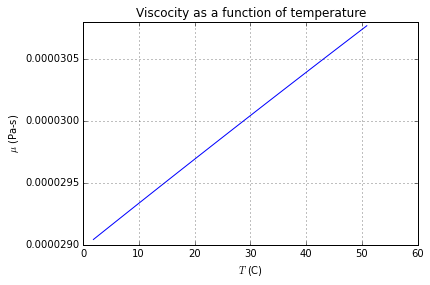

In [6]:
# Plot the data above
fig = plt.figure()
ax = plt.axes()
plt.ylabel(r'$\mu$ (Pa-s)')
plt.xlabel(r'$T$ (C)')
plt.title('Viscocity as a function of temperature')
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useOffset=False))
ax.grid(True)
plt.plot(x, z)

## Cunningham Correction Factor

The Cunningham correction factor from the equation above is a function of particle diameter and the mean free path of the carrier gas and can be calculated as 

\begin{equation}
C_c = \left[1.05\exp\left(-0.39\frac{D}{\lambda}\right)+2.34\right]\times\frac{\lambda}{D}+1
\end{equation}

for diameters less than 100 nm and

\begin{equation}
C_c = \frac{2.25\lambda}{D}+1
\end{equation}

where $D$ is the particle diameter in $\mu$m and $\lambda$ is the mean free path of the gas which can be calculated as

\begin{equation}
\lambda = \lambda_0\frac{P_0}{P}
\end{equation}

Here, $P_0$ and $\lambda_0$ define reference values.  At 0.7 atm the mean free path is 66 nm.

In [9]:
D0 = 50  # Starting diameter
D1 = 500 # Final diameter

air.T = 20

# Get a range of Cc for plotting
cc_range = [aerosol.cc(i,air) for i in range(D0,D1)]

# Range of diameter over which to plot
D = list(range(D0,D1))

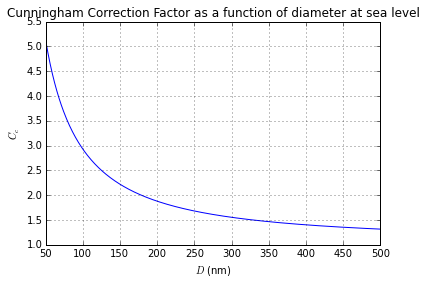

In [10]:
fig = plt.figure()
ax = plt.axes()
plt.ylabel(r'$C_c$')
plt.xlabel(r'$D$ (nm)')
plt.title('Cunningham Correction Factor as a function of diameter at sea level')
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useOffset=False))
plt.plot(D,cc_range)
ax.grid(True)

Now, we can calculate the electric mobility:

In [11]:
Zrange = [aerosol.z(D, air,1) for D in range (D0,D1)]
D = list(range(D0,D1))

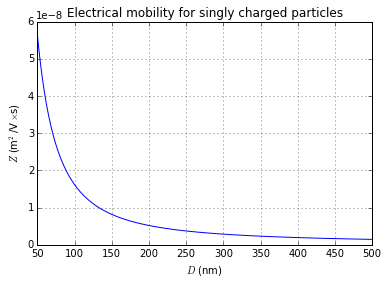

In [12]:
fig = plt.figure()
ax = plt.axes()
plt.ylabel(r'$Z$ (m$^2$/V$\times$s)')
plt.xlabel(r'$D$ (nm)')
plt.title('Electrical mobility for singly charged particles')
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useOffset=False))
plt.plot(D,Zrange)
ax.grid(True)

# Calculating the Diameter as Function of DMA Voltage

If we know the dimensions of the DMA, we may now calculate the expected particle diameter as a function of the flow rates and the DMA voltage.  Since the function is implicit (the mobility is a function of diameter), the diameter must be solved for iteratively.  This can be calculated as in Knutson and Whitby (1975) by equating the center-rod voltage to the electical mobility:

\begin{equation}
Z = \frac{q_c+q_m}{4\pi\Lambda{V}}
\end{equation}

The flows, $q_c$ and $q_m$, are the sheath flows at the entrance and exit.  $\Lambda$ is a DMA constant given by 

\begin{equation}
\Lambda = \frac{L}{\ln\left(\frac{r_{inner}}{r_{outer}}\right)}
\end{equation}

Here, $L$ is the length of the DMA column and $r_{inner}$ and $r_{outer}$ are the inner and outer radii of the annular gap in the DMA.  For the NOAA wide, these values are as follows:

* $L=0.34054$
* $r_i = 0.0312$
* $r_o = 0.03613$

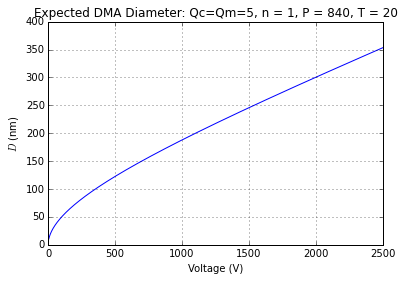

In [13]:
noaa_dma = dma.NoaaWide()

# Flows in lpm
qc = 5
qm = 5

# Maximum number of iterations for Newton-Raphson
maxit = 1000

# Low diameter for range
Vlow = 5

# High diameter for range
Vhigh = 2500

# Define range
Vrange = list(range(Vlow,Vhigh))

air.T = 20
air.P = 840

xrange = [noaa_dma.v2d(i, air, qc,qm) for i in range(Vlow,Vhigh)]
fig = plt.figure()
ax = plt.axes()
plt.ylabel(r'$D$ (nm)')
plt.xlabel(r'Voltage (V)')
plt.title('Expected DMA Diameter: Qc=Qm=5, n = 1, P = 840, T = 20')
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useOffset=False))
plt.plot(Vrange,xrange)
ax.grid(True)

# Retrieving a Size Distribution from Scan Data

From the paper Stolzenburg and McMurry [2008], we can retrieve the size distribution using the follow equation (27, from the paper):

\begin{equation}
\frac{dN}{d\ln{D_{p1}}}\bigg|_{D^*_{p1}}=\frac{N_1\left(V_1\right)a_1^*}{\frac{Q_{a1}}{Q_{s1}}\beta_1\left(1+\delta_1\right)f_c\left(D^*_{p1},1\right)\eta_{CPC}\left(D^*_{p1}\right)}
\end{equation}

This equation is accurate only under certain circumstances.  Here, 
\begin{equation}
a^*=\left(\frac{-d\ln{Z_p}}{d\ln{D_p}}\right)\bigg|_{D^*_p}
\end{equation}

and $D_p$ is the particle diameter, $D^*_p$ is the particle diameter associated with the centroid transfer function $Z^*_p$, $Q_a$ is the aerosol flow rate, $Q_s$ is the sheath flow rate, $\eta_{CPC}$ is the CPC counting efficiency and $N\left(V\right)$ is the CPC concentration at voltage $V$.

In addition, we have the two ratios
\begin{equation}
\delta = \frac{Q_s-Q_a}{Q_s+Q_a}
\end{equation}
and
\begin{equation}
\beta = \frac{Q_s+Q_a}{Q_m+Q_c}
\end{equation}

where $Q_m$ is the main excess air outlet flow rate and $Q_c$ is the clean sheath inlet flow rate.

# Reading in a DMA File

In [14]:
dfile = 'C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150306_06_05_16.txt'

# read in a file and parse the column labeled 'Date_Time' as a date object.  
# Index on the first column with the header being in the third row.
# This file uses the EOL constant and therefore has to use the lineterminator = newline
fdata = pd.read_csv(dfile, parse_dates = 'Date_Time', index_col = 0, header = 2, lineterminator = '\n')

# Show the list of column headers
list(fdata.columns.values)

['DMA_Set_Diam',
 'DMA_Diam',
 'DMA_Volts',
 'DMA_Set_Volts',
 'V_ctl',
 'CPC_Ready',
 'CPC_Flw',
 'CPC_200_Cnt',
 'CPC_20_Cnt',
 'CPC_1_Cnt',
 'CPC_Display',
 'CPC_STP',
 'CPC_Conc',
 'CPC_DAQ_Cnt',
 'Sh_Pres_PSI',
 'Sh_Temp_C',
 'Sh_Q_VLPM',
 'Sh_MassQ_SLPM',
 'Sh_SetQ_VLPM',
 'Dil_Pres_PSI',
 'Dil_Temp_C',
 'Dil_Q_VLPM',
 'Dil_MassQ_SLPM',
 'Dil_SetQ_VLPM',
 'Aer_Pres_PSI',
 'Aer_Temp_C',
 'Aer_Q_VLPM',
 'Aer_MassQ_SLPM',
 'Aer_SetQ_VLPM',
 'Comment\r']

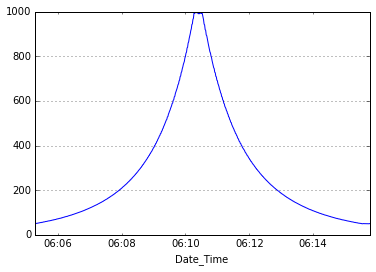

In [15]:
# Plot the diameter as a function of time
fdata['DMA_Diam'].plot()

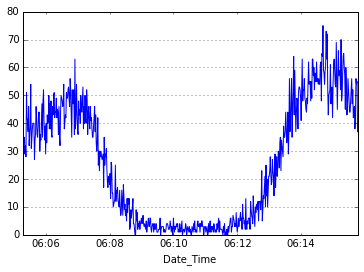

In [16]:
# Plot the 
fdata['CPC_1_Cnt'].plot()

## Aligning the Data

### Reading the Data using PANDAS

In [17]:
# Retrieve the meta data from the header
meta_data = pd.read_csv(dfile,header = 0, lineterminator = '\n', nrows = 1)
list(meta_data.columns.values)

['Date',
 'Time',
 'Scan_Number',
 'Low_Voltage',
 'High_Voltage',
 'Low_Diameter',
 'High_Diameter',
 'Scan_Time',
 'Dwell_Time',
 'Lag_Time \r']

Once the data is read in, we will need to align the up and down scans.  But first, we will need to find where the scans begin and end.

In [22]:
print(str(meta_data.Date[0]))

# Number of seconds in scan
tscan = meta_data['Scan_Time'].values[0]
tdwell = meta_data['Dwell_Time'].values[0]
vhigh = meta_data['High_Voltage'].values[0]
vlow = meta_data['Low_Voltage'].values[0]
dhigh = meta_data['High_Diameter'].values[0]
dlow = meta_data['Low_Diameter'].values[0]

03/06/15


### Truncating and Padding the Data

The lag is 13.0


C:\Anaconda\lib\site-packages\pandas\core\index.py:687: FutureWarning: slice indexers when using iloc should be integers and not floating point
  "and not floating point",FutureWarning)


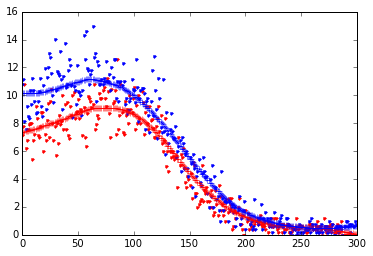

In [17]:
# Retrieve the concentration and diameters of interest
cpc_cnt = fdata['CPC_1_Cnt'].values/fdata['CPC_Flw'].values

#d = fdata['DMA_Diam'].values;
up_data = fdata

# Reverse the entire data frame
down_data = fdata.iloc[::-1]


cpc_up = fdata['CPC_1_Cnt'].values[0:tscan]/fdata['CPC_Flw'].values[0:tscan]
cpc_down = down_data['CPC_1_Cnt'].values[(tdwell):(tscan+tdwell)]/down_data['CPC_Flw'].values[(tdwell):(tscan+tdwell)]


# Get the lag
corr = np.correlate(cpc_up,cpc_down,mode = 'full')
corr = corr[corr.size/2:]

# Here is the lag as applied to the two sets.  The lag is divided by two because
# the lag applies to both sets (up and down)
delta = 13 # a fudge factor for alignment purposes
f=floor(corr.argmax(axis=0)/2+ delta)

print('The lag is ' + str(f))

# Shift the up data with the number of zeros padding on the end equal to the lag
cpc_up = np.pad(fdata['CPC_1_Cnt'].values[f:tscan]/fdata['CPC_Flw'].values[f:tscan],[0,f], 'constant', constant_values=(0,0));

cpc_up[np.where(np.isinf(cpc_up))]=0.0
cpc_up[np.where(np.isnan(cpc_up))]=0.0


# Padding the down scan is trickier - if the parameter f (should be the lag in the correlation)
# is larger than the dwell time, we will have a negative resize parameter - this is no good.
# Pad the front with the number of zeros that goes beyond the end (front in the reveresed array).
# This makes sense.  I guess.
pad = 0
if (f>tdwell):
    pad = f-tdwell
    f = tdwell

# Shift the down data so that we pad the front and back appropriately
cpc_down  = np.pad(down_data['CPC_1_Cnt'].values[(tdwell-f):(tscan+tdwell-(f+pad))]/
                   down_data['CPC_Flw'].values[(tdwell-f):(tscan+tdwell-(f+pad))], 
                   [0,pad], 'constant', constant_values= (0,0))

# Truncate the data from the up scan
up_data = up_data.iloc[:tscan]

# Get the voltage from the up scan
vup = up_data['DMA_Volts'].values

# Get the mean of all the columns in up_data
mup = up_data.mean(axis=0)

smooth_p = 0.3
smooth_up = sm.nonparametric.lowess(cpc_up,up_data.DMA_Diam.values, frac = smooth_p, it = 1, missing='none')


# Truncate the down data.  In Chuck's code, this is tdwell:tscan+tdwell.
# But, I don't understand why this would be since we are flipping the 
# distribution.  Seems to me that the conditions of interest should 
# be in the range of 0 to tscan.

cpc_down[np.where(np.isinf(cpc_down))]=0.0
cpc_down[np.where(np.isnan(cpc_down))]=0.0
down_data = down_data.iloc[:tscan]
smooth_down = sm.nonparametric.lowess(cpc_down,down_data['DMA_Diam'].values, frac = smooth_p, missing='none')

# Get the down voltages.
vdown = down_data['DMA_Volts'].values

# Get the mean of all the columns in down_data
mdown = down_data.mean(axis=0)

air.t = mup.Aer_Temp_C
air.p = mup.Aer_Pres_PSI

cdhigh = noaa_dma.v2d(vhigh,air, mup.Sh_Q_VLPM, mup.Sh_Q_VLPM)
cdlow = noaa_dma.v2d(vlow,air, mup.Sh_Q_VLPM, mup.Sh_Q_VLPM)

# Number of bins for the interpolated matrix of diameters
numbins = 300

# Array for scan to interpolate diameters over; base is e
diam_interp = np.logspace(np.log10(1),np.log10(1000), numbins)

#fig = plt.figure()
#ax = plt.axes()

#plt.plot(ndiam,x,'.')
#ax.set_xscale('log')

#ax.xaxis
# plot the truncated data
plt.plot(cpc_up, 'r.', cpc_down, 'b.',smooth_up[:,1], 'r+', smooth_down[:,1], 'b+')

## Retrieving the Charge Distribution

The following equations were pulled from two different sources.  For particles smaller than 1 micron, we can use the Wiedensohler [1988] approximation of the bipolar charge distribution.  This looks like

\begin{equation}
f\left(N\right)=10^{\sum_{i=0}^{5}a_i\left(N\right)\left(\log{\frac{D_p}{nm}}\right)^i}
\end{equation}

where the constants defined by $a_i$ are given in the paper and in the code below, $D_p$ is the particle size in nm and $N$ is the number of charges.

For larger particles, use Gunn.  The solution in this case is

\begin{equation}
f\left(N\right)=\frac{e}{\sqrt{4\pi^2\varepsilon_0D_pkT}}\exp\left[{-\frac{N-\frac{2\pi\varepsilon_0D_pkT}{e^2}\ln\left(\frac{c_{NI+}Z_{I+}}{c_{NI-}Z_{I-}}\right)}{\frac{4\pi\varepsilon_0D_pkT}{e^2}}}\right]
\end{equation}

where $\varepsilon_0$ is the dielectric constant, $e$ is the elementary electronic charge, $k$ is Boltzman's constant and $c_{I\pm}$ and $Z_{I\pm}$ are the ion concentration and mobility respectively.  The concentration of negative and positive ions is assumed to be equal and the ratio of the positive to negative mobility was measured to be 0.875 by Wiedensohler et al. [1986].

Now, let's plot the charging efficiency over a multiplicity of diameters to see if we have this right.

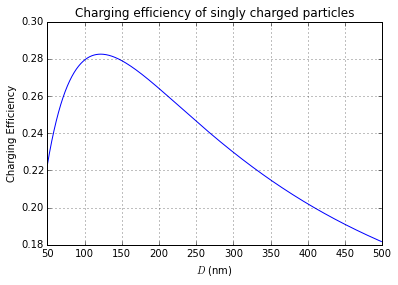

In [18]:
# Set the diameter range to 50 - 500 nm
dp0 = 50
dp1 = 500
plt.plot(list(range(dp0,dp1)),[aerosol.ndistr(i) for i in range(dp0,dp1)])
plt.ylabel(r'Charging Efficiency')
plt.xlabel(r'$D$ (nm)')
plt.title('Charging efficiency of singly charged particles')
plt.grid()

This plot compares favorably with the results from **Table 2** in Wiedensohler [1987].  The code for the charging efficiency was taken from the Igor SMPS code and some of the coefficients are slightly different, so the results should be slightly different.

## Solve for Diameter with a Known Mobility

### Example

What follow is an example of how to use the function above.  We can test this using the functions above for the electic mobility.  Start with a 213 nm particle at 23 degrees Celsius and 850 mb.

In [19]:
air.t = 23
air.p = 850

z = aerosol.z(213,air,1)
print(z)

8.61682465115e-09


The resulting mobility is $8.61\times10^{-9}$ m$^2$/(Vs).  Using this, we can plug the mobility in and solve using a starting diameter of 100 nm.

In [20]:
d0 = 1e-9
aerosol.z2d(z,air,1)

213.0

The result is a particle of diameter 213 nm.

## Solve for the FWHM at the given Diameter

In [155]:
'''
Return the full-width, half-max of the transfer function in diameter space.
This implementation ignores diffusion broadening.
@param dp: particle size in nm
@param qa: aerosol flow rate in lpm
@param qs: aerosol flow rate in lpm
@param T: temperature in degrees Celsius
@param P: pressure in millibars
@return: Width of transfer function in nm.
'''
def xferFWHM(dp,qa,qs,gas):
    beta = float(qa)/float(qs)
    
    # Retrieve the center mobility
    Zc = aerosol.z(dp,gas,1)
        
    # Upper bound of the mobility
    Zm = (1-beta/2)*Zc
    
    # Lower bound of the mobility
    Zp = (1+beta/2)*Zc
    
    return aerosol.z2d(Zm, gas, 1)-aerosol.z2d(Zp, gas, 1)

### Example of Using FWHM Function

The following is an example of how to use the transfer function to find the FWHM.

In [156]:
air.t = 20
air.p = 850
xferFWHM(100,1,10,air)

5.6422676853702995

The result is a width that is 5.64 nm.  This compares favorably with Chuck's work which shows a width of 5.61nm for the same conditions.

## Bringing it all together

Now that we have all of the raw functionality in order, we can begin to put a distribution together by looping.

In [244]:
# Make sure the conditions are good
air.t = mup.Aer_Temp_C
air.p = mup.Aer_Pres_PSI

# Calculate the diameters to use
sup = [noaa_dma.v2d(i,air, mup.Sh_Q_VLPM, mup.Sh_Q_VLPM) for i in up_data.DMA_Set_Volts.values]
#output_sd = []
ls = len(sup)
dlogd = np.zeros(ls) # calculate dlogd
fwhm = np.zeros(ls) # hold width
dnlogd =  np.zeros(ls)

for e,i in enumerate(sup):
    try:
        fwhm[e] = xferFWHM(i, mup.Aer_Q_VLPM, mup.Sh_Q_VLPM,air )
        #output_sd[e] = smooth_up[e,1]
        dlogd[e] = np.log10(i+fhwm[e]/2)-np.log10(i-fhwm[e]/2)
        #dnlogd[e] = smooth_up[e,1]/dlogd[e]
    except (ValueError,ZeroDivisionError):
        fwhm[e] = np.nan
        print('Handling divide by zero error')
    except:
        fwhm[e] = np.nan
        print('Handling unknown error: ' + str(sys.exc_info()[0]))
print(sup[100])

116.157403696


In [246]:
print(up_data.DMA_Set_Volts.values)

[   37.419477    38.004535    38.59874     39.202236    39.815168
    40.437683    41.069931    41.712065    42.364238    43.026608
    43.699335    44.382579    45.076506    45.781283    46.497079
    47.224066    47.96242     48.712319    49.473942    50.247473
    51.033099    51.831007    52.641391    53.464446    54.300369
    55.149362    56.011629    56.887378    57.776819    58.680167
    59.597638    60.529455    61.47584     62.437023    63.413233
    64.404707    65.411682    66.434402    67.473112    68.528063
    69.599507    70.687704    71.792915    72.915406    74.055448
    75.213314    76.389283    77.583639    78.796669    80.028664
    81.279922    82.550744    83.841435    85.152306    86.483673
    87.835856    89.20918     90.603977    92.020581    93.459334
    94.920582    96.404677    97.911976    99.442842   100.997643
   102.576754   104.180554   105.80943    107.463773   109.143982
   110.850462   112.583623   114.343881   116.131662   117.947395
   119.791

## Correct for Multiple Charges

In the below function, we will loop through the concentrations starting from the lowest diameter and look for multiply charged particles that would have been mistakenly classified as larger particles.  These misclassified particles will be removed from the bins and of those larger particles and placed in the current bin.  To do this, we will have to search for the bin which contains the nearest value to the multiply charged value.  This can be achieved by using a search function demonstrated below:

In [260]:
# The following shows two different ways to get the index closest to the value 136.5

index = min(enumerate(sup), key =lambda x: abs(x[1]-136.5))
idx = (np.abs(np.asarray(sup) - 136.5)).argmin()
print(idx)
print(index)

118
(118, 136.50272095690903)


This function will return both the index and the value in a list.  

In [271]:
def chargeCorr(diam,dn,gas,n=3,pos_neg=-1):
    '''
    Correct the input concentrations for multiple charges.
    
    This function does not return anything as it handles array input by reference.
    
    Parameters
    ----------
    diam:       array of float
                array of diameters in nm
    dn:         array of integers
                Array of particle concentrations corresponding to diameter 'diam'
    gas:        gas object
                Gas object that defines the properties of the gas
    n:          int, optional
                Number of charges to consider.  Default is 3.
    pos_neg:    int, optional
                Positive or negative one indicating whether to consider positive or negative charges.
                Default is -1.
    
    Returns
    -------
    None
    
    '''
    
    dn_removed = np.zeros(len(dn))
    
    single_frac = np.zeros(len(dn))
    
    # Flip both the incoming diamter array and the concentration distribution
    rdiam = diam[::-1]
    rdn = dn[::-1]
    
    dn_raw = dn
    dn_work = dn
    dn_raw = dn
    
    # We are working backwards, so we need to have the length to get this all right...
    l = len(dn)-1
    
    # Find the value closest to diameter d in the array diam
    fmin = lambda d: (np.abs(np.asarray(diam) - d)).argmin()
    
    for i,d in enumerate(rdiam):
        
        # Get the fraction of particles that are singly charged
        single_frac[i] = aerosol.ndistr(d,pos_neg,gas.t)
        
        #print("Diameter is " + str(d))
        #print("Single charge fraction is " + str(single_frac[i]))
        
        for j in reversed(range(2,n+1)):
            ne = j*pos_neg
            
            # Ratio of singly charge particles to particles with charge ne
            c_rat = single_frac[i]/aerosol.ndistr(d,ne,gas.t)
            
           # print("c_rat = " + str(c_rat))
            #print("charge is " + str(ne))
            #print("charge efficiency is " + str(aerosol.ndistr(d,ne,gas.t)))
            
            z = aerosol.z(d,gas,1)
            
            z_mult = abs(ne*aerosol.z(d,gas,pos_neg))
            
            #print("Z_mult is " + str(z_mult))
            
            d_mult = aerosol.z2d(z_mult, gas, 1)
            #print("d_mult is " + str(d_mult))
            
            # Do NOT try to move particles for which we don't have a diameter
            if (d_mult >= diam[0]):
                # Find the index of the multiple charges
                k = fmin(d_mult)

                #print("k is " + str(k))
                #print("l-i is = " + str(l-i))

                # Calculate the number to move
                n2move = min(dn_raw[l-i]/c_rat, dn_work[l-i])

                #print("n2move is " + str(n2move))

                #print("dn[k] is = " + str(dn[k]))

                dn[k]  += n2move 
                dn_work[l-i] -= n2move

                #print("dn[k] + n2move is = " + str(dn[k]))

                #print("dn[l-i] is = " + str(dn[l-i]))

                dn[l-i] -= n2move

                #print("dn[l-i] - n2move is = " + str(dn[l-i]))
        
        # Correct for single charging
    single_frac = single_frac[::-1]
    plt.plot(dn, 'g')
    #print(dn[0])
    #print(single_frac[0])
    dn = dn/single_frac
    
    plt.plot(dn,'b')
    #print(single_frac)
            
            
    return None
                  

### Demonstation of Correction

Continuing with the above examples from the file.

1.30075055808


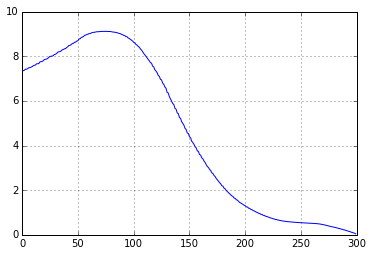

In [272]:
plt.plot(smooth_up[:,1])
plt.grid()

ax = plt.axes()

smooth_up[45,1]
print(smooth_up[200,1])

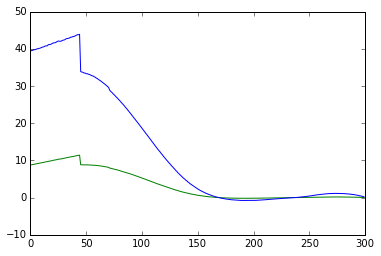

In [273]:
# Copy the array so that we don't have to run all the way back
output_sd = np.copy(smooth_up[:,1])  # Space for the size distribution
#plt.plot(output_sd)
chargeCorr(sup,output_sd,air)
#plt.plot(output_sd, 'r', smooth_up[:,1], 'b')
#plt.plot(output_sd)
#ax = plt.axes()
#ax.set_xlim(0,50)


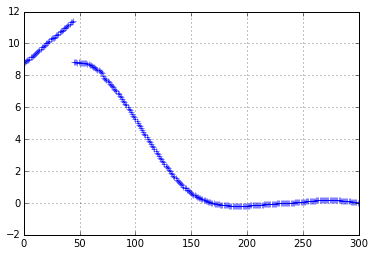

In [264]:
plt.plot(output_sd, '+')
ax = plt.axes()
plt.grid()